In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch
import matplotlib.patches as patches
from collections import Counter
import matplotlib.patheffects as path_effects

import matplotlib.cm as cm
import matplotlib.colors as mcolors

from highlight_text import ax_text, fig_text
from PIL import Image
from mplsoccer import add_image
import urllib
from urllib.request import urlopen

pd.set_option('display.max_columns', None)

In [27]:
df = pd.read_csv(r"D:\FData\LaLiga_2024_25\till_gw11.csv")

In [28]:
df = df[df['type']!='Carry'].reset_index(drop=True)

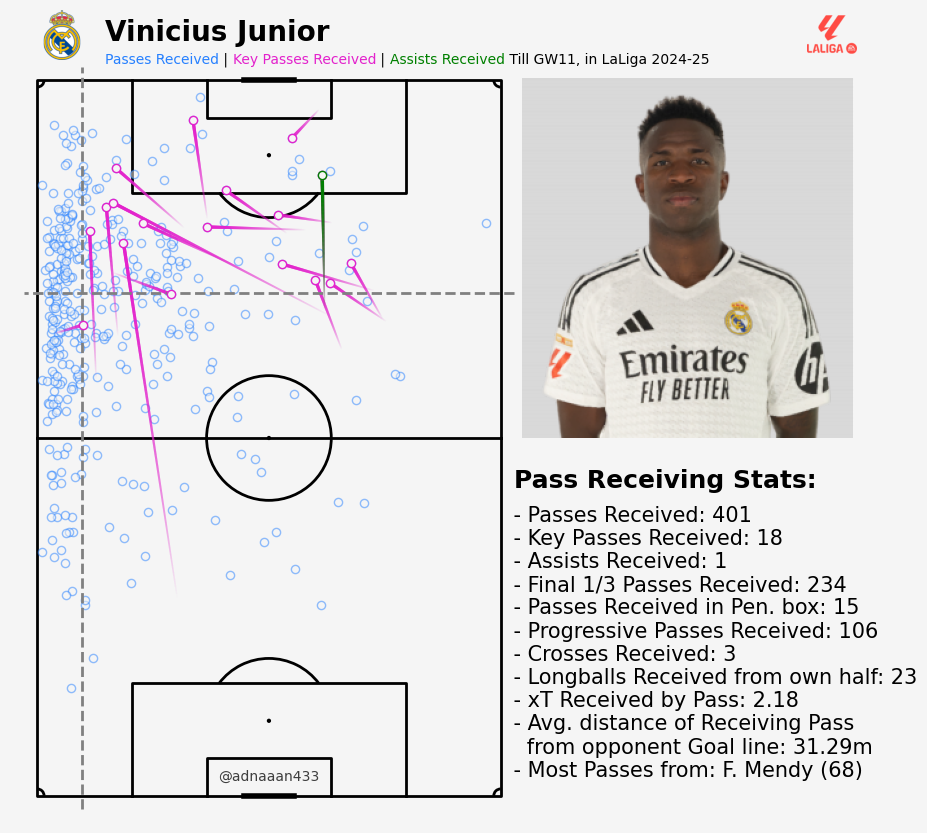

In [29]:
def plot_pass_recieve(ax, pname):
    dfp = df[(df['type']=='Pass') & (df['outcomeType']=='Successful') & (df['name'].shift(-1)==pname)]
    dfkp = dfp[dfp['qualifiers'].str.contains('KeyPass')]
    dfas = dfp[dfp['qualifiers'].str.contains('IntentionalGoalAssist')]
    dfnt = dfp[dfp['endX']>=70]
    dfpen = dfp[(dfp['endX']>=87.5) & (dfp['endY']>=13.6) & (dfp['endY']<=54.6)]
    dfpro = dfp[(dfp['x']>=35) & (dfp['prog_pass']>=9.11)]
    dfcros = dfp[(dfp['qualifiers'].str.contains('Cross'))]
    dfxT = dfp[dfp['xT']>=0]
    dflb = dfp[(dfp['qualifiers'].str.contains('Longball')) & (dfp['x']<=52)]
    cutback = dfp[((dfp['x'] >= 88.54) & (dfp['x'] <= 105) & 
                       ((dfp['y'] >= 40.8) & (dfp['y'] <= 54.4) | (dfp['y'] >= 13.6) & (dfp['y'] <= 27.2)) & 
                       (dfp['endY'] >= 27.2) & (dfp['endY'] <= 40.8) & (dfp['endX'] >= 81.67))]

    name_counts = dfp['shortName'].value_counts()
    name_counts_df = name_counts.reset_index()
    name_counts_df.columns = ['name', 'count']
    name_counts_df = name_counts_df.sort_values(by='count', ascending=False)  
    name_counts_df = name_counts_df.reset_index()

    pitch = VerticalPitch(pitch_type='uefa', pitch_color='#f5f5f5', line_color='k', corner_arcs=True, linewidth=2)
    pitch.draw(ax=ax)
    # pr = pitch.lines(dfp.x, dfp.y, dfp.endX, dfp.endY, color='#2680ff', lw=2.25, alpha=0.25, comet=True, transparent=True, ax=ax)
    kp = pitch.lines(dfkp.x, dfkp.y, dfkp.endX, dfkp.endY, color='#e322cc', lw=2.35, comet=True, transparent=True, ax=ax)
    ass = pitch.lines(dfas.x, dfas.y, dfas.endX, dfas.endY, color='green', lw=2.5, comet=True, transparent=True, ax=ax)

    ax.scatter(dfp.endY, dfp.endX, s=35, color='#f5f5f5', alpha=0.5, edgecolor='#2680ff', zorder=1)
    ax.scatter(dfkp.endY, dfkp.endX, s=35, color='#f5f5f5', edgecolor='#e322cc', zorder=3)
    ax.scatter(dfas.endY, dfas.endX, s=35, color='#f5f5f5', edgecolor='green', zorder=3)

    ax.hlines(dfp['endX'].median(), xmin=-2, xmax=70, color='gray', linewidth=2, linestyle='--')
    ax.vlines(dfp['endY'].median(), ymin=-2, ymax=107, color='gray', linewidth=2, linestyle='--')

    ax.text(58, 112, f'{pname}', fontsize=20, fontweight='bold', ha='left', va='center')
    ax_text(58,108, s='<Passes Received> | <Key Passes Received> | <Assists Received> Till GW11, in LaLiga 2024-25', ha='left', va='center', 
            highlight_textprops=[{'color':'#2680ff'},{'color':'#e322cc'},{'color':'green'}], ax=ax)

    ax.text(-2, 48, 'Pass Receiving Stats:', fontsize=18, fontweight='bold', ha='left', va='top')
    ax.text(2, 46, f'''
    - Passes Received: {len(dfp)} (2nd most)
    - Key Passes Received: {len(dfkp)}
    - Assists Received: {len(dfas)}
    - Final 1/3 Passes Received: {len(dfnt)} (most)
    - Passes Received in Pen. box: {len(dfpen)}
    - Progressive Passes Received: {len(dfpro)}
    - Crosses Received: {len(dfcros)}
    - Longballs Received from own half: {len(dflb)}
    - xT Received by Pass: {dfxT['xT'].sum().round(2)}
    - Avg. distance of Receiving Pass
      from opponent Goal line: {round(105-dfp['endX'].median(),2)}m
    - Most Passes from: {name_counts_df['name'][0]} ({name_counts_df['count'][0]})''', fontsize=15, ha='left', va='top')
    ax.text(34, 2.75, '@adnaaan433', ha='center', va='center', alpha=0.75)

    team_name = dfp['teamName'].unique()
    team_name = team_name[0]
    # Take data coordinates and transform them to normalized figure coordinates
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    
    ax_coords = DC_to_NFC((68,108))
    ax_size = 0.05
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    fotmob_url = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    fotmob_url = fotmob_url.replace(' ', '%20')
    club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    image_ax.imshow(club_icon)
    image_ax.axis('off')

    ax_coords = DC_to_NFC((-1,52.5))
    ax_size = 0.36
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='#d9d9d9', anchor='C')
    fotmob_url = f'file:///D:/FData/LaLiga_2024_25/Player_Img/{pname}.html'
    fotmob_url = fotmob_url.replace(' ', '%20')
    club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    image_ax.imshow(club_icon)
    image_ax.axis('on')
    image_ax.set_xticks([])
    image_ax.set_yticks([])
    for spine in image_ax.spines.values():
        spine.set_visible(False)

    ax_coords = DC_to_NFC((-45,108))
    ax_size = 0.05
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    fotmob_url = f'file:///D:/FData/Leagues_logos/LaLiga%20.html'
    fotmob_url = fotmob_url.replace(' ', '%20')
    club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    image_ax.imshow(club_icon)
    image_ax.axis('off')
    
    return

fig,ax=plt.subplots(figsize=(10,10), facecolor='#f5f5f5')
plot_pass_recieve(ax, 'Vinicius Junior')

In [7]:
fwds = df[df['position'] == 'FW']
unique_names = fwds['name'].unique()
sorted_names = sorted(unique_names)
print(sorted_names)

['Abel Ruiz', 'Adri Embarba', 'Aitor Ruibal', 'Alejo Veliz', 'Alex Kral', 'Alexander Sorloth', 'Alvaro Djalo', 'Alvaro Rodriguez', 'Andre Almeida', 'Angel Correa', 'Ante Budimir', 'Antoine Griezmann', 'Arnaut Danjuma', 'Asier Villalibre', 'Assane Diao', 'Ayoze Perez', 'Bertug Yildirim', 'Bojan Miovski', 'Borja Iglesias', 'Cedric Bakambu', 'Chimy Avila', 'Christantus Uche', 'Chuki', 'Cyle Larin', 'Dani Gomez', 'Dani Rodriguez', 'Diego Garcia', 'Fabio Silva', 'Gabriel Misehouy', 'Gerard Moreno', 'Gorka Guruzeta', 'Hugo Duro', 'Iago Aspas', 'Inaki Williams', 'Isaac Romero', 'Isi Palazon', 'Javi Guerra', 'Javi Puado', 'Juanmi Latasa', 'Julian Alvarez', 'Kelechi Iheanacho', 'Kike Garcia', 'Kylian Mbappe', 'Luka Romero', 'Mamadou Sylla', 'Marcos Andre', 'Miguel de la Fuente', 'Mikel Oyarzabal', 'Nicolas Pepe', 'Oliver McBurnie', 'Orri Oskarsson', 'Rafa Mir', 'Randy Nteka', 'Raul Garcia', 'Robert Lewandowski', 'Rodrygo', 'Sebastien Haller', 'Selim Amallah', 'Sergio Camello', 'Sheraldo Becker'

In [37]:
def pr(pname):
    dfp = df[(df['type'] == 'Pass') & (df['outcomeType'] == 'Successful') & (df['name'].shift(-1) == pname)]
    dfkp = dfp[dfp['qualifiers'].str.contains('KeyPass')]
    dfas = dfp[dfp['qualifiers'].str.contains('IntentionalGoalAssist')]
    dfnt = dfp[dfp['endX'] >= 70]
    dfpen = dfp[(dfp['endX'] >= 87.5) & (dfp['endY'] >= 13.6) & (dfp['endY'] <= 54.6)]
    dfpro = dfp[(dfp['x'] >= 35) & (dfp['prog_pass'] >= 9.11)]
    dfxT = dfp[dfp['xT'] >= 0]
    dfcros = dfp[(dfp['qualifiers'].str.contains('Cross'))]
    dflb = dfp[(dfp['qualifiers'].str.contains('Longball')) & (dfp['x']<=52)]
    
    pr_count = len(dfp)
    kp_count = len(dfkp)
    as_count = len(dfas)
    ft_count = len(dfnt)
    pen_count = len(dfpen)
    pro_count = len(dfpro)
    xT_count = round(dfxT['xT'].sum(), 2)
    mean_dist = round(105 - dfp['endX'].median(),2)
    cros_count = len(dfcros)
    lb_count = len(dflb)
    
    return {
        'Total Pass Rec.': pr_count,
        'KeyPass Rec.': kp_count,
        'Assist Rec.': as_count,
        'Final1/3 Pass Rec.': ft_count,
        'Pass Rec. in Pen. box': pen_count,
        'Prog. Pass. Rec.': pro_count,
        'Cross Rec.': cros_count,
        'Longballs from own1/2': lb_count,
        'xT Received': xT_count,
        'Mean Dist. From Oppo. Goal line': mean_dist
    }

# pnames = ['Álvaro Morata', 'Joselu', 'Georges Mikautadze', 'Kai Havertz', 'Rasmus Højlund', 
#           'Cristiano Ronaldo', 'Benjamin Sesko', 'Marcus Thuram', 'Romelu Lukaku',
#           'Denis Dragus', 'Memphis Depay', 'Marko Arnautovic', 'Kwadwo Duah', 
#           'Baris Alper Yilmaz', 'Harry Kane', 'Róbert Bozeník', 'Gianluca Scamacca']  # Replace with your actual list of player names
pnames = sorted_names

# Create a list of dictionaries to store the counts for each player
data = []

for pname in pnames:
    counts = pr(pname)
    counts['Name'] = pname
    data.append(counts)

# Convert the list of dictionaries to a DataFrame
counts_df = pd.DataFrame(data)

# Sort the DataFrame by 'pr_count' in descending order
counts_df = counts_df.sort_values(by='xT Received', ascending=False)

counts_df.head(10)

Total Pass Rec.  KeyPass Rec.  Assist Rec.  Final1/3 Pass Rec.  \
54              247            26            7                 128   
10              163            20            3                  83   
65              187            15            2                  95   
62              139            23            3                  71   
42              334            30            1                 207   
16              107            10            1                  68   
5               165            18            2                  80   
18              156            10            2                  79   
0               152            11            1                  82   
31              144            10            1                  64   

    Pass Rec. in Pen. box  Prog. Pass. Rec.  Cross Rec.  \
54                     38                93          11   
10                     35                91          19   
65                     32                84          20   
62                     21                63           8   
42                     48               119           4   
16                     21                62          11   
5                      32                74          16   
18                     18                68           9   
0                      22                78           8   
31                     18                63          11   

    Longballs from own1/2  xT Received  Mean Dist. From Oppo. Goal line  \
54                     14         4.64                            33.18   
10                     52         4.37                            34.12   
65                     69         3.93                            34.65   
62                     49         3.57                            34.65   
42                     15         3.50                            30.08   
16                     35         3.35                            31.19   
5                      51         3.12                            35.39   
18                     18         2.70                            34.33   
0                      10         2.60                            33.81   
31                     39         2.39                            36.80   

                  Name  
54  Robert Lewandowski  
10        Ante Budimir  
65        Vedat Muriqi  
62       Thierno Barry  
42       Kylian Mbappe  
16     Bertug Yildirim  
5    Alexander Sorloth  
18      Borja Iglesias  
0            Abel Ruiz  
31           Hugo Duro

In [11]:
counts_df = counts_df.sort_values(by='pen_count', ascending=False)
counts_df

pr_count  kp_count  as_count  ft_count  pen_count  pro_count  xT_count  \
2         70         9         0        55         15         36      1.56   
4         60         9         0        43         15         26      1.32   
7         48         7         0        35         12         24      1.41   
13        59         6         0        25          9         25      0.83   
9         86         7         1        44          9         35      0.60   
1         68         4         1        25          6         33      0.80   
6         47         7         0        24          6         18      0.28   
3         44         2         0        27          5         28      0.82   
12        76         3         0        45          4         24      0.53   
10        37         0         0        21          4         15      0.43   
15        36         2         0        16          4         13      0.29   
8         48         3         1        19          4         18      0.25   
11        22         4         1        10          4         10      0.25   
0         43         7         1        19          3         15      0.38   
14        28         1         0        13          3         12      0.12   
5         48         3         0        20          2         20      0.41   

                  Name  
2          Kai Havertz  
4    Cristiano Ronaldo  
7        Romelu Lukaku  
13          Harry Kane  
9        Memphis Depay  
1   Georges Mikautadze  
6        Marcus Thuram  
3       Rasmus Højlund  
12  Baris Alper Yilmaz  
10    Marko Arnautovic  
15   Gianluca Scamacca  
8         Denis Dragus  
11         Kwadwo Duah  
0        Álvaro Morata  
14      Róbert Bozeník  
5       Benjamin Sesko